# Predicting Song Popularity from Audio Features 

Over the course of the Covid-19 pandemic, I have focused my studies on data science and predictive analytics. One day, as I was running to the sound of Kenny Loggins' "Danger Zone," it hit me: it would be fascinating to investigate the relationships different aspects of music share with one another. In what ways can we describe different aspects of a song? What features are most important to determining a song's popularity; can we derive a model that, given data describing these features, can predict the popularity of a song?

In the following investigation I hope to answer these questions. Thankfully, a dataset suited to helping me derive insights into answering these questions has been compiled and posted to Kaggle by Yamac Eren Ay. Ay's Spotify dataset contains over 170,000 songs collected from the Spotify Web API, SpotiPy.

My plan for my investigation is as follows:

## Road Map

1. Data Cleaning and Initial Exploration
2. Feature Engineering
3. Exploratory Data Analysis
4. Model Building with Hyperparameter Tuning
5. Conclusions

### Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_palette('Greens')

## 1. Data Cleaning 

In [2]:
# read in csv
spot = pd.read_csv('../data/songs.csv')

# preview data
print('Row and Column Dimensions: {}'.format(spot.shape), sep='\n\n')
spot.head()

Row and Column Dimensions: (174389, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [3]:
# get an overview of each column, the number of values in each, and their respective data types
spot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

### Cleaning Objectives

a) Check for duplicates

b) Check for null values

c) Determine features to drop

#### a) Dealing with Duplicates

In [4]:
# find proportion of duplicate songs within dataset
spot['name'].duplicated().value_counts()
print(spot['name'].duplicated().value_counts()[1] / len(spot['name']))

0.2143254448388373


Over 20% of the data consists of duplicates. To obtain accurate results, it is best to remove them.

In [5]:
def dupeDeleter(spotify_df, name_array):
    '''replace duplicate entries with an associated metric with one entry and the mean of the metric; for spotify dataframe'''
    
    # create list of unique songs
    unique_songs = pd.unique(name_array)
    # instantiate empty dictionary
    master = {}
    # iterate through unique song list, assigning each song as a key and an empty list as its value
    for song in unique_songs:
        master[song] = []
    
    # iterate through integers to facilitate loop
    for i in range(0, len(spotify_df)):
        # access each song in dictionary by passing in its name, then append the current iterance's popularity score to the song's list
        master[spotify_df.iloc[i,12]].append(spotify_df.iloc[i,13])
    
    # iterate through dictionary, splitting keys and values from each other
    for key, value in master.items():
        # append the mean of all popularity scores within the popularity score list as the final element
        master[key].append(np.mean(master[key]))

    # iterate through integers to facilitate loop
    for i in range(0, len(spot)):
        # access the song name, pass into dictionary to access list, access mean and impute the corresponding song's popularity score in the dataframe with mean
        spotify_df.iloc[i,13] = master[spotify_df.iloc[i,12]][-1]

    # drop duplicates and reset the dataframe integer indexing
    spot.drop_duplicates(inplace=True)
    spot.reset_index(inplace=True)
    spot.drop('index', axis=1, inplace=True)

    return spotify_df

In [6]:
# assign spot dataframe as output of dupeDeleter
spot = dupeDeleter(spotify_df=spot, name_array=spot['name'])

Now, every occurence of every song in the dataframe has a popularity score of its mean across all duplicates. After dropping all duplicate entries, no one song shall be overrepresented when modeling.

There are certainly other values to have imputed other than the mean, such as using the maximum of a song's popularity scores. Cleaning the duplicates in this way may introduce some bias, but it is likely the most pragmatic action to take given what information is available on how the popularity metric is computed by Spotify.

In [7]:
# drop artists, id, name, release_date, year
spot.drop(['artists','id','name','release_date', 'year'], axis=1, inplace=True)
spot.head()

# rename mode to major, so as to clarify that 1 is major and 0 is minor
spot.rename(mapper={'mode':'major'}, axis=1, inplace=True)
spot.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,major,popularity,speechiness,tempo,valence
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12.000000,0.0936,149.976,0.6340
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,41.333333,0.0534,86.889,0.9500
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4.000000,0.1740,97.600,0.6890
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17.000000,0.0425,127.997,0.0422
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2.000000,0.0768,122.076,0.2990


For the purposes of this investigation I will not be analyzing any trends related to individual artists or song titles, and the id is a residual identifier from the Spotipy API. I also dropped the year because I will not be incorporating any time-series elements for this particular project.

It is best to keep the explicit and mode features binary, rather than converting them to strings (explicit or non-explicit, minor or major). If they remain encoded as dummy variables, they are great candidates for regression modeling. At this point, I decided to rename the mode feature to major, so as to clarify that 1 indicates that a song is major and 0 that a song is minor.

## 2. Feature Engineering

### Musical Key

In [9]:
def notationConverter(input_array, map_dict):
    '''takes in an array of input, converts each element to the corresponding value from a provided dictionary'''
    
    # instantiate empty list
    outputs = []

    # iterate through input_array, for each element append the corresponding value from map_dict as a string to the output list
    for i in input_array:
        outputs.append(map_dict[i])
    
    return outputs

In [10]:
# create dictionary mapping musical keys in pitch class notation to keys, with the keys in letter form as the values
pitchclass_map = {
    0:'C',
    1:'Db',
    2:'D',
    3:'Eb',
    4:'E',
    5:'F',
    6:'Gb',
    7:'G',
    8:'Ab',
    9:'A',
    10:'Bb',
    11:'B'
}

# get array of keys in pitch class notation for all observations
pitchclass_input = spot['key']

# pass array into function
keys = notationConverter(input_array=pitchclass_input, map_dict=pitchclass_map)

# convert output from list to pandas Series
keys = pd.Series(keys)

# replace pitch class notation array with key name array
spot['key'] = keys
spot.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,major,popularity,speechiness,tempo,valence
0,0.991000,0.598,168333,0.224,0,0.000522,F,0.3790,-12.628,0,12.000000,0.0936,149.976,0.6340
1,0.643000,0.852,150200,0.517,0,0.026400,F,0.0809,-7.261,0,41.333333,0.0534,86.889,0.9500
2,0.993000,0.647,163827,0.186,0,0.000018,C,0.5190,-12.098,1,4.000000,0.1740,97.600,0.6890
3,0.000173,0.730,422087,0.798,0,0.801000,D,0.1280,-7.311,1,17.000000,0.0425,127.997,0.0422
4,0.295000,0.704,165224,0.707,1,0.000246,Bb,0.4020,-6.036,0,2.000000,0.0768,122.076,0.2990


### Song Duration

In [11]:
# change units of duration from ms to minutes
spot['duration_ms'] = spot['duration_ms'] / 60000

# rename column
spot.rename(mapper={'duration_ms':'duration_min'}, axis=1, inplace=True)
spot.head()

,acousticness,danceability,duration_min,energy,explicit,instrumentalness,key,liveness,loudness,major,popularity,speechiness,tempo,valence
0,0.991000,0.598,2.805550,0.224,0,0.000522,F,0.3790,-12.628,0,12.000000,0.0936,149.976,0.6340
1,0.643000,0.852,2.503333,0.517,0,0.026400,F,0.0809,-7.261,0,41.333333,0.0534,86.889,0.9500
2,0.993000,0.647,2.730450,0.186,0,0.000018,C,0.5190,-12.098,1,4.000000,0.1740,97.600,0.6890
3,0.000173,0.730,7.034783,0.798,0,0.801000,D,0.1280,-7.311,1,17.000000,0.0425,127.997,0.0422
4,0.295000,0.704,2.753733,0.707,1,0.000246,Bb,0.4020,-6.036,0,2.000000,0.0768,122.076,0.2990


Changing the units of duration to minutes ought to result in a more intuitive analysis after passing the data into our models.

## 3. Exploratory Data Analysis

### Univariate Analysis - Numerical

In [3]:
spot = pd.read_csv('../checkpoints/2-featureengineering.csv')
spot.head()

,acousticness,danceability,duration_min,energy,explicit,instrumentalness,key,liveness,loudness,major,popularity,speechiness,tempo,valence
0,0.991000,0.598,2.805550,0.224,0,0.000522,F,0.3790,-12.628,0,12.000000,0.0936,149.976,0.6340
1,0.643000,0.852,2.503333,0.517,0,0.026400,F,0.0809,-7.261,0,41.333333,0.0534,86.889,0.9500
2,0.993000,0.647,2.730450,0.186,0,0.000018,C,0.5190,-12.098,1,4.000000,0.1740,97.600,0.6890
3,0.000173,0.730,7.034783,0.798,0,0.801000,D,0.1280,-7.311,1,17.000000,0.0425,127.997,0.0422
4,0.295000,0.704,2.753733,0.707,1,0.000246,Bb,0.4020,-6.036,0,2.000000,0.0768,122.076,0.2990


In [5]:
# isolate numerical variables
num_index = spot.describe().columns.drop(['explicit','major'])
num = spot[num_index]
num.head()

,acousticness,danceability,duration_min,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
0,0.991000,0.598,2.805550,0.224,0.000522,0.3790,-12.628,12.000000,0.0936,149.976,0.6340
1,0.643000,0.852,2.503333,0.517,0.026400,0.0809,-7.261,41.333333,0.0534,86.889,0.9500
2,0.993000,0.647,2.730450,0.186,0.000018,0.5190,-12.098,4.000000,0.1740,97.600,0.6890
3,0.000173,0.730,7.034783,0.798,0.801000,0.1280,-7.311,17.000000,0.0425,127.997,0.0422
4,0.295000,0.704,2.753733,0.707,0.000246,0.4020,-6.036,2.000000,0.0768,122.076,0.2990


In [6]:
# compute descriptive statistics of numerical variables
num.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
count,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000,172230.000000
mean,0.501914,0.536246,3.877864,0.480989,0.194968,0.211396,-11.777780,25.901276,0.105896,116.937762,0.525249
std,0.379394,0.175858,2.452947,0.272032,0.332974,0.180661,5.690105,20.687376,0.183053,30.290836,0.264392
min,0.000000,0.000000,0.082283,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.091300,0.414000,2.770000,0.248000,0.000000,0.099300,-14.935750,3.000000,0.035200,93.834000,0.311000
50%,0.523000,0.547000,3.428625,0.463000,0.000498,0.138000,-10.867000,27.000000,0.045400,115.657000,0.537000
75%,0.896000,0.668000,4.426667,0.708000,0.238000,0.270000,-7.532000,41.000000,0.076000,134.991000,0.744000
max,0.996000,0.988000,88.971700,1.000000,1.000000,1.000000,3.855000,100.000000,0.971000,243.507000,1.000000


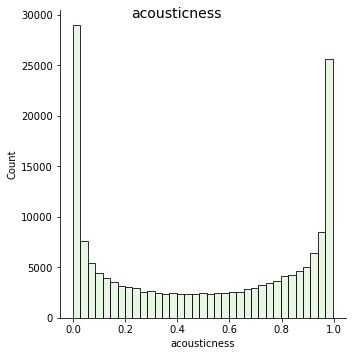

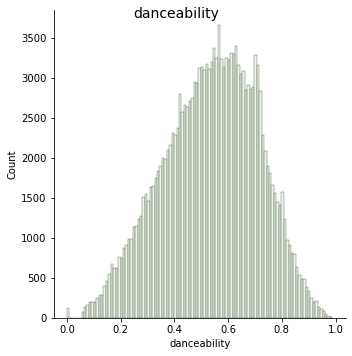

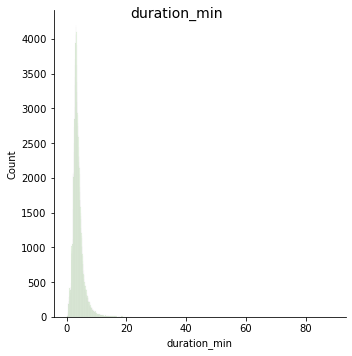

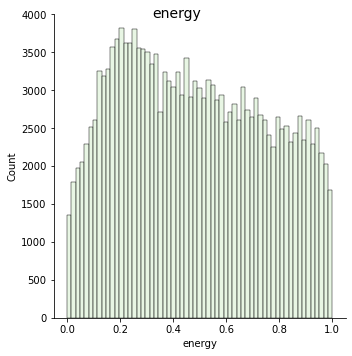

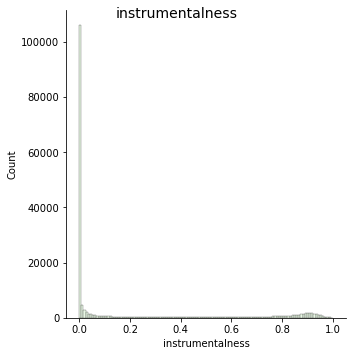

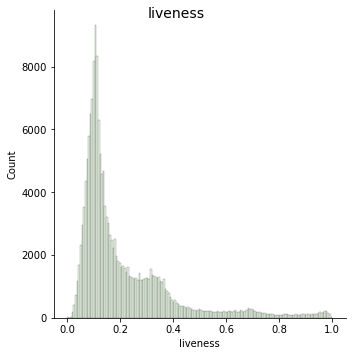

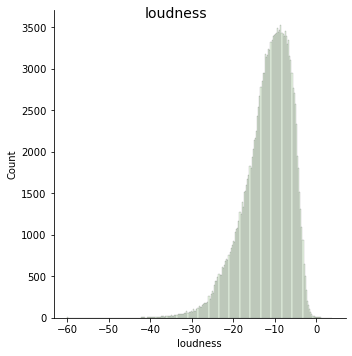

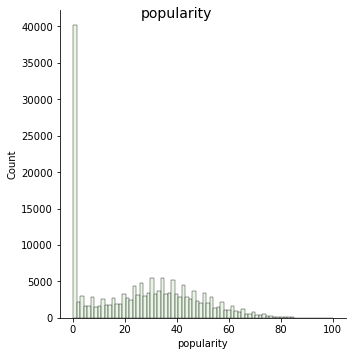

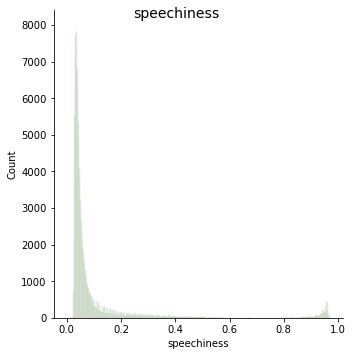

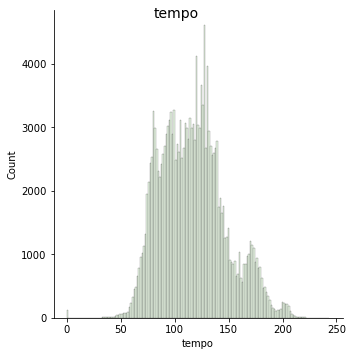

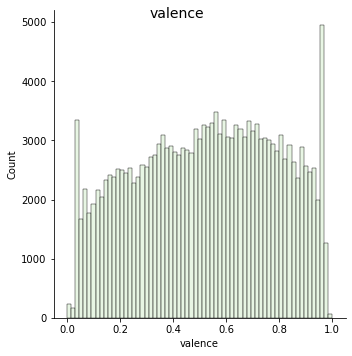

In [7]:
# visualize the distribution of each variable via histogram
for col in num.columns:
    if col.startswith('year') == False:
        ax = sns.displot(x=col, kind='hist', data=num)
        ax.fig.suptitle(col, size=14)
    else:
        ax = sns.displot(x=col, kind='hist', bins=10, data=num)
        ax.fig.suptitle(col, size=14)
        ax.set_xticklabels(rotation=45)

Acousticness - "A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic."

Acousticness is quite polarized. Across the dataset, the Spotipy API attributed acousticness scores in what appears to be a bimodal or beta distribution. This seems reasonable given that this feature represents a confidence measure, and is thereby bounded between 0 and 1. The probability that Spotify has virtually no confidence or near absolute confidence that a given track is acoustic appears high compared to ambiguous cases. As is, this moreso provides information on the tendencies of Spotify's own classification models than anything else.

Danceability - "Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."

In contrast, danceability closely follows the normal distribution. It is skewed just slightly to the left, which in this case means the data's center is slightly biased towards higher levels of danceability.

Duration_ms - "The duration of the track in milliseconds."

Each unit on the x-axis is in millions of milliseconds, meaning that one unit is equal to 1000 seconds or 16.67 minutes. For our analysis, it would likely be best to convert these values to seconds or minutes, which would lead to more intuitive insights. Most of the data appears to be between 0 and 16.67 minutes. This aligns with our intuition, where I imagine few people would want to listen to a single track lasting beyond 10 minutes or so. Inspecting the outliers might lead to additional insights.

Energy - "Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."

Energy appears to follow a right-skewed distribution. We may need to transform it before including it in any models. For now, it appears that the center of the distribution is somewhat skewed toward less energetic music.

Instrumentalness - "Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0."

Instrumentalness appears right-skewed, demonstrating a tendency toward tracks with vocal content.

Liveness - "Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live."

Liveness appears quite right-skewed, implying that a greater proportion of tracks are recorded in studio settings.

Loudness - "The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db."

Each observation for loudness represents a track's average loudness level. Loudness appears quite left-skewed, showing a tendency toward high average loudnesses.

Popularity - "The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are."

There are many songs with a popularity score of 0; beyond that appears to be one long tail that comprises a miniature distribution of its own. Hence, there are *many* tracks that are virtually unknown, with a relatively uniform probability than a given song has any popularity rating greater than 0.

Speechiness - "Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks."

The description for Speechiness is intriguing, insofar that it provides lower and upper bounds with which to categorize entries. This may be an interesting opportunity for feature engineering later on. There is also a tendency towards lower Speechiness values, implying a preference toward instrumental tracks. Given that high speechiness indicates more speech and high instrumentalness indicates less speech, we would expect these metrics to be inversely related.

Tempo - "The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration."

Tempo appears to closely follow the normal distribution, with a center at roughly 120 beats per minute.

Valence - "A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)."

Valence appears to have a multi-modal distribution. Many songs are clearly high-valence and clearly low-valence. The slight peak at a valence = 0.5 likely forms due to higher levels of uncertainty in classifying a song, plus the songs that contain both high-valence and low-valence elements.

Year - As far as I can tell, it is a derivation of the release_date feature. It is not listed under the [Spotify Web API Documentation](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) I've been referencing thus far.

Songs across the dataset seem to be somewhat normally distributed across the past century, except the high number of songs that were released between 2010 and 2020.

### Univariate Analysis - Categorical

In [8]:
# isolate categorical variables
cat_index = spot.columns.drop(num.columns)
cat = spot[cat_index]
cat.head()

,explicit,key,major
0,0,F,0
1,0,F,0
2,0,C,1
3,0,D,1
4,1,Bb,0


The proportion of songs that are explicit is 6.80%
The proportion of songs that are major is 70.31%


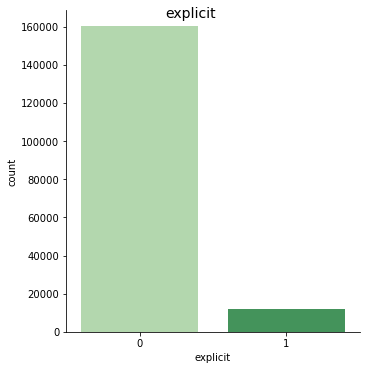

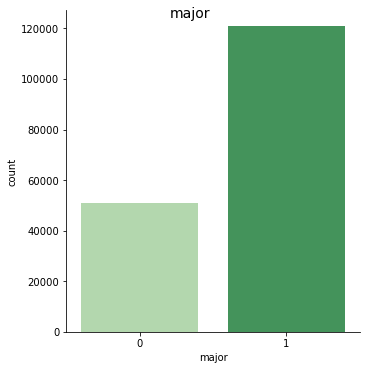

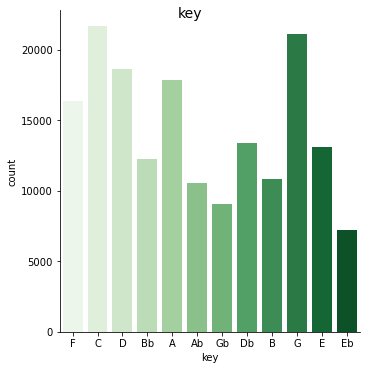

In [9]:
discrete_cat_var = ['explicit','major','key']

# visualize distribution of the levels of each categorical variable via barplots
for var in discrete_cat_var:
    ax = sns.catplot(x=var, kind='count', data=cat, palette='Greens')
    ax.fig.suptitle(var, size=14)
    if (var.startswith('explicit') == True) | (var.startswith('major') == True) :
        counts = cat[var].value_counts()
        prop_1 = counts[1] / (counts[0] + counts[1])
        print('The proportion of songs that are ' + str(var) + ' is {:.2%}'.format(prop_1))

In [52]:
# pivot table exploring explicit songs and songs in major keys
ptable = pd.pivot_table(data=cat, index='major', columns='explicit', aggfunc='count', margins=True)
ptable

key               
explicit       0      1     All
major                          
0          46406   4721   51127
1         114120   6983  121103
All       160526  11704  172230

In [47]:
# pivot table exploring the relationships between the categorical variables
ptable = pd.pivot_table(data=cat, index='key', columns='explicit', aggfunc='count')
ptable['Proportion of Non-Explicit'] = ptable.iloc[:,0] / (ptable.iloc[:,0] + ptable.iloc[:,1])
ptable['Proportion of Explicit'] = 1-ptable['Proportion of Non-Explicit']

ptable

major       Proportion of Non-Explicit Proportion of Explicit
explicit      0     1                                                  
key                                                                    
A         17011   854                   0.952197               0.047803
Ab         9817   731                   0.930698               0.069302
B          9486  1356                   0.874931               0.125069
Bb        11515   768                   0.937475               0.062525
C         20465  1245                   0.942653               0.057347
D         17684   990                   0.946985               0.053015
Db        11518  1860                   0.860966               0.139034
E         12399   735                   0.944038               0.055962
Eb         7008   216                   0.970100               0.029900
F         15683   704                   0.957039               0.042961
G         19872  1241                   0.941221               0.058779
Gb         8068  1004                   0.889330               0.110670

In [11]:
# sort to find the keys that contain songs with the highest proportion of explicit content
ptable.nlargest(n=4, columns='Proportion of Explicit')

explicit,0,1,Proportion of Non-Explicit,Proportion of Explicit
key,,,,
Db,11518,1860,0.860966,0.139034
B,9486,1356,0.874931,0.125069
Gb,8068,1004,0.889330,0.110670
Ab,9817,731,0.930698,0.069302


For the binary variables explicit and mode (now renamed to major), a 0 indicates a song lacking expletives or in a minor key, whereas a 1 indicates a song with expletives or in a major key, respectively.

The key feature refers to the musical key a song is, and is encoded in pitch-class notation. The key of C is encoded as 0, the key of C# as 1, etc. This is certainly a good candidate for feature engineering. This variable is not ordinal, so no valuable information would be lost from reverting these numbers back to their keys expressed in letters (which we did earlier). We may also derive the key signatures for these songs; perhaps there is some correlation with the number of sharps or flats a song has and its popularity? I suspect not, because key signatures are functions of each key, but it could be an interesting exercise for another time.

From visual inspection, we see that songs written in the keys of C, G, D, and A occurred most frequently. In addition, the majority of tracks seem to be non-explicit and in a major key. The four keys with the highest proportion of songs that are explicit, as depicted by the above pivot table, are the keys of Db, B, Gb, and Ab. There is no overlap between the most frequently occuring keys and the keys with the highest proportion of songs that are explicit.

I am intrigued to explore the relationship between the categorical variables key and mode with respect to the numerical variables valence and popularity. We would expect that happy songs (high-valence) are correlated with major = 1 (major key). For now, though, we'll stick with predicting popularity.

In [53]:
# mean popularity score for each musical key
pd.pivot_table(spot, index='key', values='popularity')

,popularity
key,
A,27.412222
Ab,25.119342
B,26.681492
Bb,24.141962
C,26.084937
D,26.989166
Db,25.605414
E,27.561998
Eb,21.237848


It appears that the mean popularity for each key is roughly the same. I suspect that it won't affect our model outputs, but we'll have to investigate more to see.

### Bivariate Analysis

Text(0.5, 1.0, 'Correlation Heatmap of Song Features')

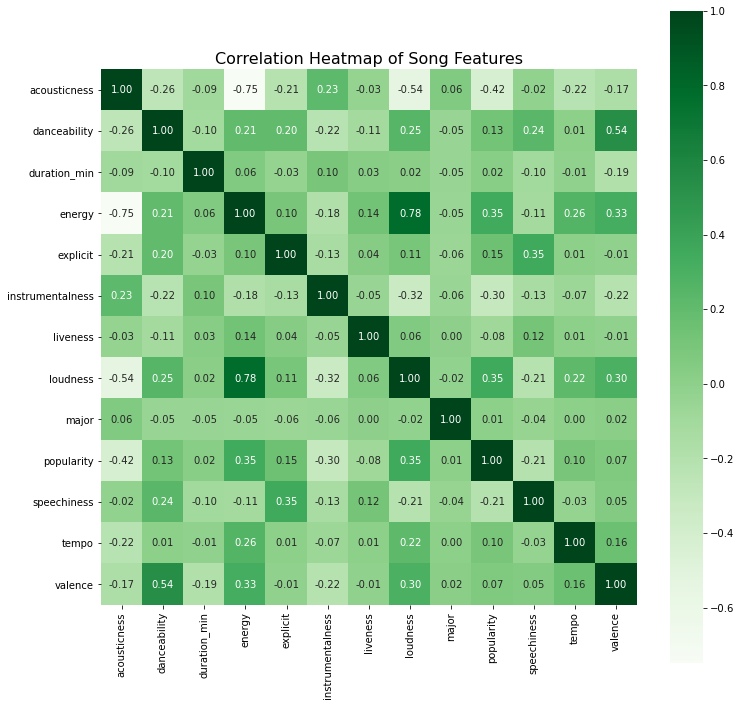

In [54]:
# correlation heatmap

plt.figure(figsize=(12,12))

ax = sns.heatmap(
    spot.corr(method='pearson'),
    cmap='Greens',
    square=True,
    annot=True,
    fmt='.2f'
)

ax.set_title('Correlation Heatmap of Song Features', fontsize=16)

Popularity seems to have a weak negative correlation with the confidence that a track is acoustic, implying that Spotify users may have a preference for digital music.

There is a weak positive correlation with energy, implying preference for fast and loud tracks.

This is validated by a similar weak positive correlation for loudness.

Finally, Popularity has a moderate positive correlation with year. Based upon Spotipy's definition of Popularity, we likely cannot claim that modern music is more popular than older music. However, we might be able to infer that Spotify users tend to listen to newer songs more than older ones.

Aside from popularity, loudness and energy appear to have a strong positive correlation. Energy and acousticness share a strong negative correlation. Valence and danceability also appear to share a moderate positive correlation.

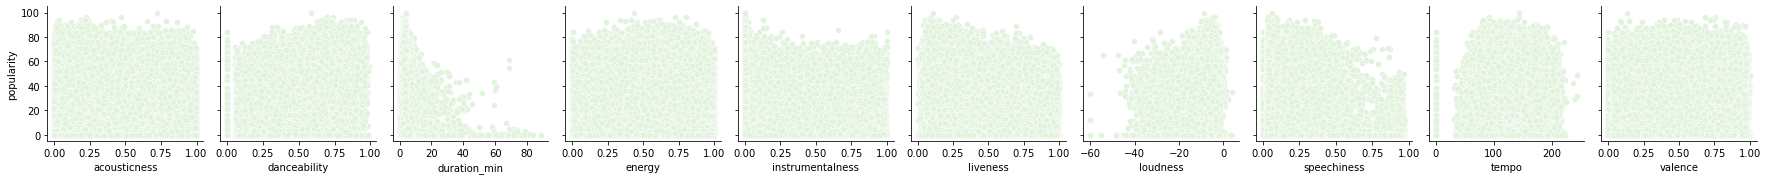

In [56]:
# pairplots with target variable "popularity" on y-axes and predictor variables on x-axes
cols = ['acousticness', 'danceability', 'duration_min', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

ax = sns.pairplot(data=spot, x_vars=cols, y_vars='popularity', kind='scatter')

Although creating scatterplots to illuminate each predictor's relationship with popularity is usually helpful for intuition-building, the sheer volume of observations makes these visualizations difficult to interpret. All that's left for us is to build, run, and evaluate our models.

## 4. Model Building and Hyperparameter Tuning

### Building the Pipeline

In [6]:
# import dependencies
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
# isolate predictor variables
X = spot.drop('popularity', axis=1)

# isolate target variable
y = spot.popularity

# isolate categorical and numerical feature names
cat_predictors = ['explicit','key','major']
num_predictors = ['acousticness','danceability','duration_min',
                'energy','instrumentalness', 'liveness',
                'loudness','speechiness','tempo','valence']

#### KNN Regressor

In [8]:
# instantiate model
knn = KNeighborsRegressor()

# preprocessing for feature columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_predictors),
    (StandardScaler(), num_predictors),
    remainder='passthrough')

In [10]:
# pass in preprocessing and model steps into pipeline object
pipeline = make_pipeline(preprocessor, knn)

# create hyperparameter space for n_neighbors, with values increasing by 1 from 1 to 25
params = {'kneighborsregressor__n_neighbors': np.arange(1, 26)}

# subset training and test sets for the predictors and the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardize y_train and y_test (i.e. standardizing the target feature popularity)
y_train, y_test = scale(y_train), scale(y_test)

# perform grid search style cross validation to find the optimal value for the n_neighbors hyperparameter
cv = GridSearchCV(pipeline, param_grid=params)

# fit the model with optimized hyperparameters to training set
cv.fit(X_train, y_train)

# generate predictions for the test set
y_pred = cv.predict(X_test)

# print the optimal model parameters
print(cv.best_params_)

# print the optimal model r-squared value
print(cv.score(X_test, y_test))

{'kneighborsregressor__n_neighbors': 25}
0.4224897344423102


Through the use of Grid Search Cross Validation, we can determine that the optimal number of neighbors for the KNN Regressor is 25.

Given the KNN Regressor model's Multiple $ R^{2} $ of 0.4225, 42.2% of the variation in popularity can be explained by the aforementioned predictor variables.

In [11]:
# compute and print root mean squared error of predictions and standard deviation of target variable
rmse_knn = mean_squared_error(y_test, y_pred, squared=False)
nrmse_knn = rmse_knn/(y.max()-y.min())
print(rmse_knn)
print(nrmse_knn)

0.7599409618895996
0.007599409618895996


#### Ordinary Least Squares Linear Regression

In [100]:
# instantiate model
ols = LinearRegression()

# preprocessing for feature columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_predictors), # encode dummy variables for categorical features
    remainder='passthrough')

In [101]:
# pass in preprocessing and model steps into pipeline object
pipeline = make_pipeline(preprocessor, ols)

# subset training and test sets for the predictors and the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# fit the model to the training set
pipeline.fit(X_train, y_train)

# generate predictions for the test set
y_pred = pipeline.predict(X_test)

# print the optimal model r-squared value
print(pipeline.score(X_test, y_test))

0.31450921676059307


Given the Ordinary Least Squares Regression model's Multiple $ R^{2} $ of 0.3145, 31.45% of the variation in popularity can be explained by the aforementioned predictor variables.

In [102]:
# isolate categorical feature names into a list
feature_names = pipeline.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names(input_features=cat_predictors)

# concatenate categorical feature names and previous list of the names of numerical predictors
feature_names = np.concatenate(
    [feature_names, num_predictors])

# create dataframe matching the name of each feature with its respective regression coefficient
summary = pd.DataFrame(
    pipeline.named_steps.linearregression.coef_,
    columns=['Coefficients'], index=feature_names)

summary

,Coefficients
explicit_1,11.839642
key_Ab,-0.417089
key_B,-0.679708
key_Bb,-0.595644
key_C,0.150978
key_D,0.041251
key_Db,-0.526799
key_E,0.405434
key_Eb,-0.949837
key_F,0.100724


##### Interpretation 
 - Compared to non-explicit songs, on average an explicit song is associated with an increase in popularity rating of about 11.8
 - A one unit increase in acousticness is, on average, associated with a 16 unit decrease in a song's popularity rating
 - A one unit increase in danceability is, on average, associated with a 7.2 unit increase in a song's popularity rating
 - A one unit increase in energy is, on average, associated with a 4.4 unit increase in a song's popularity rating
 - A one unit increase in instrumentalness is, on average, associated with a 15.3 unit decrease in a song's popularity rating
 - A one unit increase in liveness is, on average, associated with a 8.2 unit decrease in a song's popularity rating
 - A one unit increase in speechiness is, on average, associated with a 33.4 unit decrease in a song's popularity rating
 - A one unit increase in valence is, on average, associated with a 6 unit decrease in a song's popularity rating 

In [106]:
# compute and print root mean squared error of predictions and standard deviation of target variable
rmse_ols = mean_squared_error(y_test, y_pred, squared=False)
nrmse_ols = rmse_ols/(y.max() - y.min())
print(rmse_ols)
print(nrmse_ols)

17.12196910166978
0.1712196910166978


## 5. Conclusions

Because we standardized the numeric variables for the KNN Regressor model inputs but not in the OLS model inputs, we will attempt to compare their $ RMSE $ values by computing the $ NRMSE $ by dividing each by the difference between the maximum and minimum of popularity in the test set.

The KNN Regressor model possesses an $ RMSE = 0.760 $, and the $ NMRSE = 0.008 $. The Ordinary Least Squares Regression model possesses an $ RMSE = 17.122 $, and the $ NMRSE = 0.1712 $. In addition to producing significantly lower error, with a multiple $ R^2 = 42.2% $ the KNN model proves more effective than the OLS's multiple $ R^2 = 31.45% $. However, neither of these models explain a significant amount of the variation in popularity overall. Given that no feature was strongly correlated with popularity (as shown in the correlation heatmap), this does not come at a great surprise. Perhaps a more sophisticated model — such as Support Vector Regression — may yield nonlinear insights that could not otherwise be detected.